<p style="text-align:center;">
<img src="https://resources.digitalfutures.com/data-science/datascience-notebook-header.png"
     alt="DigitalFuturesLogo"
     style="float: center; margin-right: 10px;" />
</p>
<p>
<img src="https://miro.medium.com/max/1400/1*wiNU2uOb7vVvxDBXGJRy_g.png"
     alt="Turdus Merula"
     style="float: center" />
</p>


The following is a workbook of my capstone project at Digital Futures. The aim was to create an algorithm that will be able to identify birds based on their chirping. A dataset from https://xeno-canto.org via kaggle was used. For reasons of simplicity and versatility, the algorithm <b>only uses audio data</b> as input when making predictions. Further improvement is desired. You can read about these and a more detailed walk-through of creating the algorithm at https://aarroonn.medium.com/.

In [1]:
# LIBRARIES:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.signal import butter, lfilter
from itertools import compress

import librosa # library to manipualte audio data

from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA


%matplotlib inline

Some custom built functions were used throughout the process. I define these below.

In [2]:
# FUNCTIONS:

# BANDPASS FILTER FUNCTION:

def bandpass_00(audio, sample_rate, lowcut = 800, highcut = 7000, order = 5):
    
    '''Creates a bandpass filter for audio signals.
    
    parameters:
    - audio: np.array of signal values
    - lowcut: numeric value of lowcut frequency
    - highcut: numeric value of highcut frequency
    - sample_rate: integer sample rate of audio
    - order: numeric order of the filter
    
    output:
    np.array of filtered signal values'''
    
    nyq = sample_rate * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(N = order, Wn = [low, high], btype = 'bandpass')
    output = lfilter(b, a, audio)
    
    return output


# NOISE FILTER FUNCTION:

def denoiser_00(audio, sample_rate, aggregate = np.median, metric = 'cosine', window = 1, margin_bg = 10,
                margin_front = 10, power = 2):
    
    '''Function to separate front elements and background noise using spectrogram transformation, filtering
    nearest-neighbours and soft-mask operation.
    The function is based on one of the 'Advanced examples' from the librosa package documentation:
    https://librosa.org/doc/latest/auto_examples/plot_vocal_separation.html#sphx-glr-auto-examples-plot-vocal-separation-py
    
    parameters:
    - audio: np.array of signal values
    - sample_rate: integer sample rate of audio
    - aggregate: numpy aggregate (per-frequency) function treating the nearest neighbours of each spectrogram input column
    - metric: str distance metric used for nearest-neighbour calculation. see sklearn.neighbors.DistanceMetric for a list of options
    - window: int>=1 defining in seconds which points to consider neighbour
    - margin_bg: numeric>=0 determines the signal strength of the front element in the soft-mask operaion
    - margin_front: numeric>=0 determines the signal strength of the background element in the soft-mask operaion
    - power: numeric>0 or np.inf the power element of the soft-mask computation
    
    output:
    np.array-s of the filtered front audio and the background audio'''
    
    # getting spectrogram component and phase of Fourier-transforms of the original audio
    ft_mag, ft_phase = librosa.magphase(librosa.stft(audio))
    
    # returns a combined array of element-wise minimums of the original audio and our neighbours cosine simiarity
    # filtered array, so that out filter values will never exceed the original ones
    ft_filter = np.minimum(ft_mag,
                           librosa.decompose.nn_filter(ft_mag,
                                                       aggregate = aggregate,
                                                       metric = metric,
                                                       width = int(librosa.time_to_frames(window, sr = sample_rate))))
    
    # getting mask operations for background and front elements. the results will be our local 'magnitudes' to
    # separate out elements already present in the original audio. 'ft_filter' is our background elements. we retain
    # the front audio by subtracting it from the original audio. note the symmetry between the two masks. that is
    # because the two audios serve as 'reference' to each other's masks
    
    # to save processing time, i comment out the background elements here
    #mask_bg = librosa.util.softmask(ft_filter,
    #                                margin_bg * (ft_mag - ft_filter),
    #                                power = power)
    mask_front = librosa.util.softmask(ft_mag - ft_filter,
                                       margin_front * ft_filter,
                                       power = power)
    
    # retaining the front and background audio signals
    
    # to save processing time, i comment out the background elements here
    front = mask_front * ft_mag
    #bg = mask_bg * ft_mag
    audio_front = librosa.istft(front * ft_phase)
    #audio_bg = librosa.istft(bg * ft_phase)
    
    return audio_front#, audio_bg


# TIME SAMPLING FUNCTION:

def look_pass(list01):
    
    '''Custom function taking in a boolean list. It was used to find points where our signal just passed a
    threshold value.'''
    
    list00 = []
    
    for i in range(len(list01) - 1):
        if (list01[i], list01[i + 1]) == (False, True):
            list00.append(i + 1)
            
    return list00


def tsampler_01(audio, sample_rate, sample_length = 0.5, look_ahead = 0.05, threshold = -15.):
    
    '''Function to create a sample of given length, from around the first relevant signal strength of audio.
    
    parameters:
    - audio: np.array of signal values
    - sample_rate: int sample rate of audio
    - sample_length: numeric>0 length of desired sample output(s) in seconds
    - look_ahead: numeric>0 length of how many seconds before reaching the threshold should be included in the final sample
    - threshold: numeric value of threshold point in dB. only signals exceeding will be sampled
    
    output:
    - a list of np.arrays of audio signals'''
    
    # for a more stable evaluation of local amplitude of the signal its converted to rms
    rms = librosa.feature.rms(y = audio)[0]
    
    # calculating time arrays for the original and rms signals
    t01 = librosa.frames_to_time(np.arange(len(audio)), hop_length = 1, sr = sample_rate)
    t02 = librosa.frames_to_time(np.arange(len(rms)), sr = sample_rate)
    
    # creating a boolean mask, to let through values above our threshold using our function from before
    rms_bool = np.where(librosa.amplitude_to_db(rms, ref = np.max) >= threshold, True, False)
    t02 = [t02[x] for x in look_pass(rms_bool)]
    
    # using our sample length, we cut the original audio to sample size. we also return the cutoff points (t_val)
    t_bool = [np.where((t01 > x - look_ahead), True, False) for x in t02]
    t_val = [round(x - look_ahead, 2) for x in t02]
    samples = [np.array(list(compress(audio, x)))[: int(sample_rate * sample_length) + 1] for x in t_bool]
    
    return samples, t_val


# ALL TOGETHER:

def audio_treatment(audio, sample_rate = 16000, track = False, track_v = 0, gen = None):
    
    '''Function to combine the audio manipulating sub-functions.
    
    parameters:
    - audio: np.array of signal values
    - sample_rate: int sample rate of audio
    - track: boolean value of whether the progress should be tracked
    - track_v: int value of the last element to be processed
    - gen: a generator object providing value steps
    
    output:
    np.array of processed audio signal'''
    
    a_t = bandpass_00(audio = audio, sample_rate = sample_rate)
    a_t = denoiser_00(audio = a_t, sample_rate = sample_rate)
    a_t, t_v = tsampler_01(audio = a_t, sample_rate = sample_rate)
    f_t = [np.abs(librosa.stft(x)) for x in a_t]
    if track == True:
        print(f'{next(gen)} / {track_v} finished')
        
    return f_t, t_v


## Checking the data:

The following section is about reading the data in and carrying out some very basic quality check and exploration.

In [3]:
# importing dataset:

df_00 = pd.read_csv('train.csv')
df_00.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
0,3.5,no,aldfly,1 (mono),2013-05-25,Not specified,25,XC134874.mp3,Not specified,Alder Flycatcher,...,134874,https://www.xeno-canto.org/134874,United States,Jonathon Jongsma,Empidonax alnorum_Alder Flycatcher,-92.962,Not specified,8:00,Jonathon Jongsma,Creative Commons Attribution-ShareAlike 3.0
1,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135454.mp3,both,Alder Flycatcher,...,135454,https://www.xeno-canto.org/135454,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
2,4.0,no,aldfly,2 (stereo),2013-05-27,both,39,XC135455.mp3,both,Alder Flycatcher,...,135455,https://www.xeno-canto.org/135455,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
3,3.5,no,aldfly,2 (stereo),2013-05-27,both,33,XC135456.mp3,both,Alder Flycatcher,...,135456,https://www.xeno-canto.org/135456,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...
4,4.0,no,aldfly,2 (stereo),2013-05-27,both,36,XC135457.mp3,level,Alder Flycatcher,...,135457,https://www.xeno-canto.org/135457,United States,Mike Nelson,Empidonax alnorum_Alder Flycatcher,-82.1106,0-3(s),08:30,Mike Nelson,Creative Commons Attribution-NonCommercial-Sha...


In [4]:
df_00.columns

Index(['rating', 'playback_used', 'ebird_code', 'channels', 'date', 'pitch',
       'duration', 'filename', 'speed', 'species', 'number_of_notes', 'title',
       'secondary_labels', 'bird_seen', 'sci_name', 'location', 'latitude',
       'sampling_rate', 'type', 'elevation', 'description', 'bitrate_of_mp3',
       'file_type', 'volume', 'background', 'xc_id', 'url', 'country',
       'author', 'primary_label', 'longitude', 'length', 'time', 'recordist',
       'license'],
      dtype='object')

In [5]:
df_00.dtypes

rating              float64
playback_used        object
ebird_code           object
channels             object
date                 object
pitch                object
duration              int64
filename             object
speed                object
species              object
number_of_notes      object
title                object
secondary_labels     object
bird_seen            object
sci_name             object
location             object
latitude             object
sampling_rate        object
type                 object
elevation            object
description          object
bitrate_of_mp3       object
file_type            object
volume               object
background           object
xc_id                 int64
url                  object
country              object
author               object
primary_label        object
longitude            object
length               object
time                 object
recordist            object
license              object
dtype: object

In [6]:
# creating a dictionary of ebird codes to species names, so later we can match these back:

dict_ebird = {}
for i in df_00.ebird_code.unique():
    dict_ebird[i] = df_00[df_00.ebird_code == i].species.unique()[0]

## Cleaning and formatting:

This section retreives only the necessary columns for filtering and audio processing, and does some minimal formatting 
(defining categories and setting data types).

In [7]:
# since the aim is to work only with audio data, only the necessary columns are kept:

df_01 = df_00[['rating', 'ebird_code', 'duration', 'filename', 'sampling_rate', 'type']].copy()
df_01.head()

,rating,ebird_code,duration,filename,sampling_rate,type
0,3.5,aldfly,25,XC134874.mp3,48000 (Hz),call
1,4.0,aldfly,36,XC135454.mp3,44100 (Hz),"call, song"
2,4.0,aldfly,39,XC135455.mp3,44100 (Hz),"call, song"
3,3.5,aldfly,33,XC135456.mp3,44100 (Hz),"call, song"
4,4.0,aldfly,36,XC135457.mp3,44100 (Hz),"call, song"


In [8]:
# we haven't null values

df_01.isnull().sum()

rating           0
ebird_code       0
duration         0
filename         0
sampling_rate    0
type             0
dtype: int64

In [9]:
df_01.shape

(21375, 6)

In [10]:
df_01.dtypes

rating           float64
ebird_code        object
duration           int64
filename          object
sampling_rate     object
type              object
dtype: object

In [11]:
# the type of record have more than 1,200 unique values. we want to categorise these into much fewer groups:

df_01.type.unique()

array(['call', 'call, song', 'song', ...,
       'call, song, vocal and mechanical sounds', 'calls, female',
       'chimp call, male, song'], dtype=object)

In [12]:
# getting rid of capitalisation:

df_01.type = [x.lower() for x in df_01.type]

In [13]:
# sorting out the many different inputs of chirp types into 3 major groups – song, call and miscellaneous:

df_01.type = np.where(['song' in x for x in df_01.type], 'song', df_01.type)
df_01.type = np.where(['call' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['duet' in x for x in df_01.type], 'song', df_01.type)
df_01.type = np.where(['alarm' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['zweeoo' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['chip' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['coo' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['whistle' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where(['wisthle' in x for x in df_01.type], 'call', df_01.type)
df_01.type = np.where((df_01.type != 'song') & (df_01.type != 'call'), 'misc', df_01.type)

In [14]:
df_01.type.unique()

array(['call', 'song', 'misc'], dtype=object)

In [15]:
# setting sample rates to integer format:

df_01.sampling_rate = df_01.sampling_rate.str[0: 5]
df_01.sampling_rate = df_01.sampling_rate.astype('int64')

In [16]:
df_01.dtypes

rating           float64
ebird_code        object
duration           int64
filename          object
sampling_rate      int64
type              object
dtype: object

## Feature engineering:

### Setting up a managable subset

Reading audio in and processing it in python is a lengthy process. To save time, I only used a smaller set of samples to train the model and create the algorithm.

In [17]:
# limiting our data to good quality recordings, under a minute with at least 16kHz sampling rate. this is because we
# want to be able to detect 8kHz frequencies, so by the Nyquist sampling theorem, we need double the sample rate:

df_02 = df_01[(df_01.rating >= 3) & (df_01.duration < 61) & (df_01.sampling_rate >= 16000) &
              (df_01.type == 'song')].copy()

In [18]:
# list the most populated datasets, summing around 300 samples:

df_02.groupby('ebird_code').ebird_code.count().sort_values(ascending = False)[: 5].sum()

305

In [19]:
# creating a list of bird types for our restricted sample:

list_ebird = df_02.groupby('ebird_code').ebird_code.count().sort_values(ascending = False)[: 5].index

In [20]:
# retaining the desired birds:

df_02 = df_02[([x in list_ebird for x in df_02.ebird_code])].copy()
df_02.reset_index(drop = True, inplace = True)

In [21]:
# thinking ahead, we create two dictionaries that can be used to provide numeric values for our model and translate it
# back:

bird_dict = {}
for i in range(len(df_02.ebird_code.unique())):
    bird_dict[df_02.ebird_code.unique()[i]] = i
    
dict_bird = {}
for i in range(len(df_02.ebird_code.unique())):
    dict_bird[i] = df_02.ebird_code.unique()[i]

### Reading in audio data:

The following accesses the actual .mp3 files in the directory system and reads them in as an array of amplitude values as the `'samp'` column of data frame `df_02`.

In [22]:
# creating a file path from where we can read the audio in:

df_02['path'] = ['train_audio/' + df_02.ebird_code[x] + '/' + df_02.filename[x] for x in range(len(df_02))]

In [23]:
# reading in audio files. librosa creates an array of amplitude values. this takes some time:

df_02['samp'] = df_02.path.apply(lambda x: librosa.load(x, mono = True, sr = 16000, res_type = 'fft')[0])

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Try

### Processing audio data:

To format audio and retain relevant information for modeling, the `audio_treatment()` function – defined at the beginning of this book – was used.
This:
* filters the bandwith frequencies
* eliminates background noise
* detects where chirps are present and
* slices these parts to equal feature lengths

In [24]:
# to track progress of the audio processing, an infinite number generator object was set up:

def inf_seq():
    num = 1
    while True:
        yield num
        num += 1
        
gen = inf_seq()

df_02['audio_tr'] = df_02.samp.apply(lambda x: audio_treatment(x, track = True, track_v = df_02.shape[0],
                                                               gen = gen)[0])

1 / 305 finished
2 / 305 finished
3 / 305 finished
4 / 305 finished
5 / 305 finished
6 / 305 finished
7 / 305 finished
8 / 305 finished
9 / 305 finished
10 / 305 finished
11 / 305 finished
12 / 305 finished
13 / 305 finished
14 / 305 finished
15 / 305 finished
16 / 305 finished
17 / 305 finished
18 / 305 finished
19 / 305 finished
20 / 305 finished
21 / 305 finished
22 / 305 finished
23 / 305 finished
24 / 305 finished
25 / 305 finished
26 / 305 finished
27 / 305 finished
28 / 305 finished
29 / 305 finished
30 / 305 finished
31 / 305 finished
32 / 305 finished
33 / 305 finished
34 / 305 finished
35 / 305 finished
36 / 305 finished
37 / 305 finished
38 / 305 finished
39 / 305 finished
40 / 305 finished
41 / 305 finished
42 / 305 finished
43 / 305 finished
44 / 305 finished
45 / 305 finished
46 / 305 finished
47 / 305 finished
48 / 305 finished
49 / 305 finished
50 / 305 finished
51 / 305 finished
52 / 305 finished
53 / 305 finished
54 / 305 finished
55 / 305 finished
56 / 305 finished
5

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=799
  warnings.warn(


91 / 305 finished
92 / 305 finished
93 / 305 finished
94 / 305 finished
95 / 305 finished
96 / 305 finished
97 / 305 finished
98 / 305 finished
99 / 305 finished
100 / 305 finished
101 / 305 finished
102 / 305 finished
103 / 305 finished
104 / 305 finished
105 / 305 finished
106 / 305 finished
107 / 305 finished
108 / 305 finished
109 / 305 finished
110 / 305 finished
111 / 305 finished
112 / 305 finished
113 / 305 finished
114 / 305 finished
115 / 305 finished
116 / 305 finished
117 / 305 finished
118 / 305 finished
119 / 305 finished
120 / 305 finished
121 / 305 finished
122 / 305 finished
123 / 305 finished
124 / 305 finished
125 / 305 finished
126 / 305 finished
127 / 305 finished
128 / 305 finished
129 / 305 finished
130 / 305 finished
131 / 305 finished
132 / 305 finished
133 / 305 finished
134 / 305 finished
135 / 305 finished
136 / 305 finished
137 / 305 finished
138 / 305 finished
139 / 305 finished
140 / 305 finished
141 / 305 finished
142 / 305 finished
143 / 305 finished
14

/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1823
  warnings.warn(


242 / 305 finished
243 / 305 finished
244 / 305 finished
245 / 305 finished
246 / 305 finished
247 / 305 finished
248 / 305 finished
249 / 305 finished
250 / 305 finished
251 / 305 finished
252 / 305 finished
253 / 305 finished
254 / 305 finished
255 / 305 finished
256 / 305 finished
257 / 305 finished
258 / 305 finished
259 / 305 finished
260 / 305 finished
261 / 305 finished
262 / 305 finished
263 / 305 finished
264 / 305 finished
265 / 305 finished
266 / 305 finished
267 / 305 finished
268 / 305 finished
269 / 305 finished
270 / 305 finished
271 / 305 finished
272 / 305 finished
273 / 305 finished
274 / 305 finished
275 / 305 finished
276 / 305 finished
277 / 305 finished
278 / 305 finished
279 / 305 finished
280 / 305 finished
281 / 305 finished
282 / 305 finished
283 / 305 finished
284 / 305 finished
285 / 305 finished
286 / 305 finished
287 / 305 finished
288 / 305 finished
289 / 305 finished
290 / 305 finished


/Users/aron/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=799
  warnings.warn(


291 / 305 finished
292 / 305 finished
293 / 305 finished
294 / 305 finished
295 / 305 finished
296 / 305 finished
297 / 305 finished
298 / 305 finished
299 / 305 finished
300 / 305 finished
301 / 305 finished
302 / 305 finished
303 / 305 finished
304 / 305 finished
305 / 305 finished


### Formatting main features:

Before fitting the models, the fromatted audio data have to be listed and set to the correct dimensionality.

In [25]:
# creating a multi-dimensional list of our features to use for the model:

ft_list = []
for i in range(df_02.shape[0]):
    ft_list += ([[df_02.ebird_code[i], x] for x in df_02.audio_tr[i]])

In [26]:
# we create a dataframe of the features for further manipulation:

df_03 = pd.DataFrame(np.array(ft_list), columns = ['ebird_code', 'res_ft'])
df_03

<ipython-input-26-27467599e707>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_03 = pd.DataFrame(np.array(ft_list), columns = ['ebird_code', 'res_ft'])


,ebird_code,res_ft
0,boboli,"[[0.00014697404865161878, 7.348844739467114e-0..."
1,boboli,"[[0.00034299312788159175, 0.000171493859121169..."
2,boboli,"[[6.008909554458143e-05, 3.0044689539782625e-0..."
3,boboli,"[[0.0005624197640023245, 0.0002812105812231230..."
4,boboli,"[[0.0007448752041031376, 0.0003724334517560971..."
...,...,...
3535,yetvir,"[[0.0010766198698186373, 0.0005381384736923775..."
3536,yetvir,"[[0.0665201216004003, 0.03325993267823758, 9.4..."
3537,yetvir,"[[0.004078913250896789, 0.0020394337141979167,..."
3538,yetvir,"[[0.0067104613587201, 0.0033551922092250755, 1..."


In [27]:
# where the length of our res_ft does not match the maximum, it is because the threshold was reached at the end of a
# recording, so the sample is too short. we get rid of these for equal feature lengths

df_03['len_tr'] = [len(x.ravel()) for x in df_03.res_ft]

df_03 = df_03[df_03.len_tr == df_03.len_tr.max()].copy()
df_03.shape

(3524, 3)

### Creating X and y values:

In [28]:
# using our dictionary from earlier, we create y-values for our model:

df_03['value'] = df_03.ebird_code.map(bird_dict)
y_01 = df_03.value

y_01.shape

(3524,)

In [29]:
# finally, we scale all features up to the same dB level and create a 2-D array for our X-features:

res_db = np.array([librosa.amplitude_to_db(x, ref = np.max) for x in df_03.res_ft])
X_01 = np.array([x.reshape(x.shape[0] * x.shape[1], ) for x in res_db])

X_01.shape

(3524, 16400)

In [30]:
# creating test and training sets:

X_trn01, X_tst01, y_trn01, y_tst01 = train_test_split(X_01, y_01, test_size = 0.2, random_state = 42)

## Modeling:

When choosing the appropriate model, I created an initial Naive Bayesian fit to set a threshold. My main metric was accuracy as the algorithm's performance should be judged on how many birds it identifies correctly – there are no threats of either Type I or Type II errors to watch out for.

### Naive Bayesian model:

In [31]:
# to create a baseline, a simple and quick Bayesian model is trained on the data:

gnb01 = GaussianNB()
gnb01.fit(X_trn01, y_trn01)

GaussianNB()

In [32]:
y_gnb01 = gnb01.predict(X_tst01)
accuracy_score(y_tst01, y_gnb01)
# baseline it is

0.4099290780141844

### PCA:

In [33]:
# as the plan is to use a support-vector machine and not spend a lifetime gridsearching, a PCA is carried out:

pca = PCA().fit(X_01)

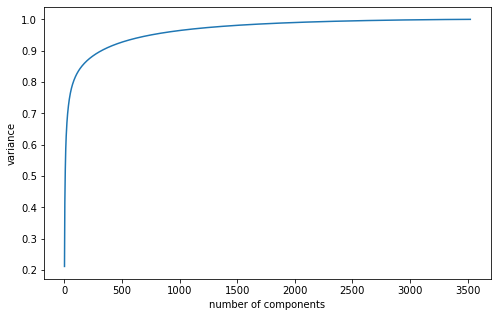

In [34]:
plt.figure(figsize = (8, 5))

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('variance')

plt.show()

In [35]:
# looking at the graph, 500 components seems like a suitable choice:

pca01 = PCA(500)
X_pca01 = pca01.fit_transform(X_01)

In [36]:
X_trn02, X_tst02, y_trn02, y_tst02 = train_test_split(X_pca01, y_01, test_size = 0.2, random_state = 42)

### SVM:

In [37]:
# we set up a support-vector machine and a grid for gridsearch:

svc01 = SVC(kernel = 'rbf', class_weight = 'balanced', probability = True)
grid01 = {'C' : [1, 5, 10, 25],
          'gamma' : [1e-07, 5e-07, 1e-06, 5e-06]}
svc_grid01 = GridSearchCV(svc01, grid01)

In [38]:
svc_grid01.fit(X_trn02, y_trn02)

GridSearchCV(estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [1, 5, 10, 25],
                         'gamma': [1e-07, 5e-07, 1e-06, 5e-06]})

In [39]:
print(svc_grid01.best_params_)
#'C': 10, 'gamma': 5e-07

{'C': 10, 'gamma': 5e-07}


In [40]:
svc02 = svc_grid01.best_estimator_
y_svc02 = svc02.predict(X_tst02)

In [41]:
accuracy_score(y_tst02, y_svc02)

0.8439716312056738

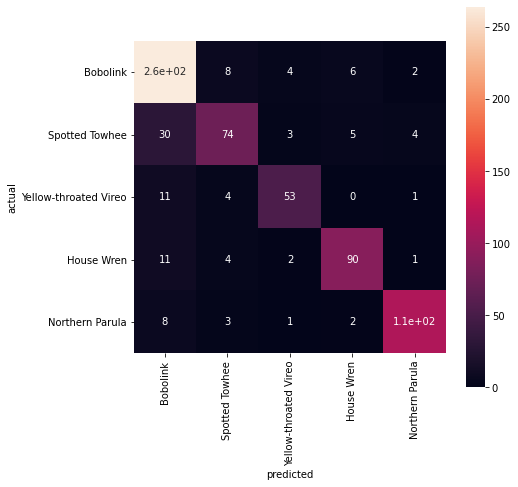

In [42]:
# creating a confusion matrix, to see our results:

mat = confusion_matrix(y_tst02, y_svc02)

plt.figure(figsize = (7, 7))

sns.heatmap(mat, square = True, annot = True,
            xticklabels = pd.Series(y_tst02.unique()).map(dict_bird).map(dict_ebird),
            yticklabels = pd.Series(y_tst02.unique()).map(dict_bird).map(dict_ebird))
plt.xlabel('predicted')
plt.ylabel('actual')

plt.show()

### Random forest ensemble:

In [43]:
rfc01 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc01.fit(X_trn01, y_trn01)

RandomForestClassifier(random_state=42)

In [44]:
y_rfc01 = rfc01.predict(X_tst01)
accuracy_score(y_tst01, y_rfc01)

0.7659574468085106

In [45]:
# testing against the PCA data too:

rfc02 = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc02.fit(X_trn02, y_trn02)

RandomForestClassifier(random_state=42)

In [46]:
y_rfc02 = rfc02.predict(X_tst02)
accuracy_score(y_tst02, y_rfc02)

0.6468085106382979

### K-nearest neighbours:

In [47]:
# based on a few trials, 2 neighbours seemed to be the best choice:

knn01 = KNeighborsClassifier(n_neighbors = 2)
knn01.fit(X_trn02, y_trn02)

KNeighborsClassifier(n_neighbors=2)

In [48]:
y_knn01 = knn01.predict(X_tst02)
accuracy_score(y_tst02, y_knn01)

0.8326241134751773

### Voting ensemble:

In [49]:
# to see if results can be improved, a soft-voting ensemble of the last three models was tried:

vcf01 = VotingClassifier(estimators = [('svc', svc02), ('rf', rfc02), ('knn', knn01)],
                         voting = 'soft', weights = [2, 1, 2])
vcf01.fit(X_trn02, y_trn02)

VotingClassifier(estimators=[('svc',
                              SVC(C=10, class_weight='balanced', gamma=5e-07,
                                  probability=True)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('knn', KNeighborsClassifier(n_neighbors=2))],
                 voting='soft', weights=[2, 1, 2])

In [50]:
y_vcf01 = vcf01.predict(X_tst02)
accuracy_score(y_tst02, y_vcf01)

0.8241134751773049

### Model evaluations:

In [51]:
# Bayesian:

print(metrics.classification_report(y_gnb01, y_tst01))

              precision    recall  f1-score   support

           0       0.18      0.71      0.29        73
           1       0.49      0.22      0.31       256
           2       0.20      0.56      0.30        25
           3       0.53      0.46      0.49       125
           4       0.85      0.48      0.62       226

    accuracy                           0.41       705
   macro avg       0.45      0.49      0.40       705
weighted avg       0.57      0.41      0.44       705



In [52]:
# SVM:

print(metrics.classification_report(y_svc02, y_tst02))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87       324
           1       0.64      0.80      0.71        93
           2       0.77      0.84      0.80        63
           3       0.83      0.87      0.85       103
           4       0.89      0.93      0.91       122

    accuracy                           0.84       705
   macro avg       0.81      0.85      0.83       705
weighted avg       0.86      0.84      0.85       705



In [53]:
# Random Forest:

print(metrics.classification_report(y_rfc02, y_tst02))

              precision    recall  f1-score   support

           0       0.95      0.57      0.72       473
           1       0.11      0.65      0.19        20
           2       0.25      0.81      0.38        21
           3       0.56      0.70      0.62        86
           4       0.74      0.90      0.82       105

    accuracy                           0.65       705
   macro avg       0.52      0.73      0.54       705
weighted avg       0.83      0.65      0.69       705



In [54]:
# KNN:

print(metrics.classification_report(y_knn01, y_tst02))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       273
           1       0.72      0.78      0.75       106
           2       0.86      0.76      0.80        78
           3       0.86      0.73      0.79       128
           4       0.88      0.93      0.90       120

    accuracy                           0.83       705
   macro avg       0.83      0.82      0.82       705
weighted avg       0.83      0.83      0.83       705



In [55]:
# Voting ensemble:

print(metrics.classification_report(y_vcf01, y_tst02))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       266
           1       0.66      0.82      0.73        93
           2       0.84      0.75      0.79        77
           3       0.88      0.70      0.78       135
           4       0.91      0.87      0.89       134

    accuracy                           0.82       705
   macro avg       0.82      0.81      0.81       705
weighted avg       0.83      0.82      0.82       705



## Using the function on audio files:

Finally, an algorithm was built to predict birds based on an audio input. The algorithm utilises the processing functions introduced in the workbook as well as the trained model. Since the support-vector machine was the best candidate, it was used for making the predictions.

In [ ]:
# PREDICTION FUNCTION:

def chirping01(audio):
    
    '''Fucntion identifying birds based on an audio record of their chirping.
    
    parameters:
    - audio: np.array of signal values
    
    output:
    - a print of specific times and associated bird types'''
    
    aud, time = audio_treatment(audio)
    # if the last samples' shape is not suitable for the model, it is discarded
    
    while aud[-1].shape != aud[0].shape:
        aud = aud[: -1]
        time = time[: -1]
        
    # we scale up the strength of the audio signal and reshape it for our model
    aud_db = np.array([librosa.amplitude_to_db(x, ref = np.max) for x in aud])
    aud_db = np.array([x.reshape(x.shape[0] * x.shape[1], ) for x in aud_db])
    
    # we perform a PCA on the signal and perform the prediction
    aud_pca = pca01.transform(aud_db)
    pred = svc02.predict_proba(aud_pca)
    
    # we create a sorted list of tuples (bird name, probability)
    list_prob = []
     
    for i in pred:
        list_p = []
        for j in range(len(i)):
            list_p.append((dict_ebird[dict_bird[j]], round(i[j] * 100, 2)))
        list_prob.append(list_p)

    list_prob.sort(key = lambda x: x[1], reverse = True)
    
    # if probabilities exceed 40%, we only print those birds. otherwise, we print all the associated types and probabilities
    for k in range(len(time)):
        print(f'At {time[k]}sec, we think it\'s:')
        if any(x[1] >= 40 for x in list_prob[k]):
            for m in list_prob[k]:
                if m[1] >= 40:
                    print(f'{m[0]} with {m[1]}% chance')
        else:
            print('Unfortunately, we cannot really say for sure but these are our guesses:')
            for n in list_prob[k]:
                print(f'{n[0]} with {n[1]}% chance')


In [56]:
chirping01(list(df_02.samp[0]))

At 0.24sec, we think it's:
Bobolink with 76.23% chance
At 0.49sec, we think it's:
Bobolink with 85.63% chance
At 0.88sec, we think it's:
Bobolink with 77.22% chance
At 1.13sec, we think it's:
Bobolink with 90.04% chance
At 1.23sec, we think it's:
Northern Parula with 64.19% chance
At 2.09sec, we think it's:
Bobolink with 92.7% chance
At 2.51sec, we think it's:
Bobolink with 81.28% chance
At 2.99sec, we think it's:
Bobolink with 87.07% chance
At 3.76sec, we think it's:
Bobolink with 88.39% chance
At 3.95sec, we think it's:
Bobolink with 83.5% chance
At 4.46sec, we think it's:
Bobolink with 93.46% chance
At 4.69sec, we think it's:
Bobolink with 92.83% chance
At 4.97sec, we think it's:
Bobolink with 95.02% chance
At 5.29sec, we think it's:
Bobolink with 94.89% chance
At 6.16sec, we think it's:
Bobolink with 94.99% chance
At 6.99sec, we think it's:
Bobolink with 95.03% chance
At 7.28sec, we think it's:
Bobolink with 94.95% chance
At 7.5sec, we think it's:
Bobolink with 94.72% chance
At 8.8

In [57]:
# checking if our model predicted well:

dict_ebird[df_02.ebird_code[0]]

'Bobolink'

In [58]:
# checking the function against a different input:

chirping01(df_02.samp[304])

At 1.17sec, we think it's:
Yellow-throated Vireo with 96.43% chance
At 2.89sec, we think it's:
Yellow-throated Vireo with 96.24% chance
At 5.07sec, we think it's:
Yellow-throated Vireo with 98.1% chance
At 6.67sec, we think it's:
Yellow-throated Vireo with 97.89% chance
At 9.29sec, we think it's:
Yellow-throated Vireo with 97.47% chance
At 10.8sec, we think it's:
Yellow-throated Vireo with 98.0% chance
At 12.72sec, we think it's:
Yellow-throated Vireo with 97.58% chance
At 15.02sec, we think it's:
Yellow-throated Vireo with 98.22% chance
At 16.97sec, we think it's:
Yellow-throated Vireo with 97.55% chance
At 18.99sec, we think it's:
Yellow-throated Vireo with 98.36% chance
At 20.91sec, we think it's:
Yellow-throated Vireo with 97.86% chance
At 22.64sec, we think it's:
Yellow-throated Vireo with 97.79% chance
At 24.17sec, we think it's:
Yellow-throated Vireo with 98.96% chance
At 24.43sec, we think it's:
Yellow-throated Vireo with 99.2% chance
At 26.22sec, we think it's:
Yellow-throated

In [59]:
dict_ebird[df_02.ebird_code[304]]

'Yellow-throated Vireo'